In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import chess
import torch
from nanoGPT.model import GPT, GPTConfig
from data_process.tokenizers import FullMoveTokenizerNoEOS, SquareTokenizer, FullMoveTokenizerWithElo
from lightning_training import LightningGPT
from playing.agents import *
from playing.testing import *
from transformers import GPT2LMHeadModel, AutoModel
import pandas as pd
from pathlib import Path
import numpy as np
from playing.agents import GPTNocheckAgent
import matplotlib.pyplot as plt
from collections import Counter

In [12]:
def load_model_from_checkpoint(checkpoint_path, config):
    pl_model = LightningGPT.load_from_checkpoint(checkpoint_path, config=config)
    model = pl_model.model.cpu()
    model.eval()
    return model

In [13]:
model_config = GPTConfig(
    block_size=301,
    vocab_size=len(FullMoveTokenizerNoEOS().vocab),
    n_layer=4,
    n_head=4,
    n_embd=256,
    bias=False,
)

model_config_big = GPTConfig(
    block_size=301,
    vocab_size=len(FullMoveTokenizerNoEOS().vocab),
    n_layer=8,
    n_head=8,
    n_embd=512,
    bias=False,
)

model_config_large = GPTConfig(
    block_size=301,
    vocab_size=len(FullMoveTokenizerNoEOS().vocab),
    n_layer=12,
    n_head=12,
    n_embd=768,
    bias=False,
)

In [14]:
def agents_from_dir(dir_path, config, agent_class=GPTAgent):
    dir_path = Path(dir_path)

    agents = []

    checkpoints = sorted(list(dir_path.rglob("*.ckpt")))


    for checkpoint in checkpoints:
        model = load_model_from_checkpoint(checkpoint, config)
        agent = agent_class(model)
        agents.append(agent)
    return agents

In [15]:
agents_small_normal = agents_from_dir("./models/standard_small_normal", model_config)
agents_small_L05_D075_W1 = agents_from_dir("./models/standard_small_L05_D075_W1", model_config)

agents_big_normal = agents_from_dir("./models/standard_big_normal", model_config_big)
agents_big_L05_D075_W1 = agents_from_dir("./models/standard_big_L05_D075_W1", model_config_big)

agents_big_L05_D075_W1_no_elo = agents_from_dir("./models/standard_big_L05_D075_W1_no_elo", model_config_big)
agents_big_L05_D075_W1_eb0 = agents_from_dir("./models/standard_big_L05_D075_W1_eb0", model_config_big)

/home/kamil/miniconda3/envs/pytorch/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.4, which is newer than your current Lightning version: v2.2.1


number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M


In [16]:
agents_negamax_gpt = agents_from_dir("./models/standard_big_L05_D075_W1_no_elo", model_config_big, agent_class=NegaMaxMaterialGPTAgent)

number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M
number of parameters: 27.27M


In [17]:
# 6 milion standard + 6 milion elite
model_best = load_model_from_checkpoint('lightning_logs/strong_play/big_L05D075W1/version_0/checkpoints/epoch=3-step=747128.ckpt', config=model_config_big)
agent_best = GPTAgent(model_best)

model_large = load_model_from_checkpoint("./models/merged_large_L05_D075_W1/epoch=2-step=562263.ckpt", config=model_config_large)
agent_large = GPTAgent(model_large)

number of parameters: 27.27M
number of parameters: 88.09M


In [18]:
from IPython.display import clear_output

maia_agents = {}

for elo in range(1100, 2000, 100):
    print(elo)
    # config = {"Threads": 1, "WeightsFile": f"./data/maia_weights/maia-{elo}.pb.gz"}
    config = {"WeightsFile": f"./data/maia_weights/maia-{elo}.pb.gz", "Threads": 1, "OutOfOrderEval": False}
    agent = UCIEngineAgent("../lc0/build/release/lc0", limit=chess.engine.Limit(nodes=1), config=config)
    maia_agents[f"maia_{elo}"] = agent

clear_output()

engine = chess.engine.SimpleEngine.popen_uci("stockfish")

def agent_vs_maia(agent, n_moves=150):
    res_to_points = {"1-0": 1, "0-1": 0, "1/2-1/2": 0.5, "*": 0.5}
    
    results = []
    points = 0


    for name, maia in maia_agents.items():
        as_white = play_game(agent, maia, n_moves=n_moves)
        as_black = play_game(maia, agent, n_moves=n_moves)

        white_stockfish_score = engine.analyse(as_white, chess.engine.Limit(time=1))["score"].white()
        black_stockfish_score = engine.analyse(as_black, chess.engine.Limit(time=1))["score"].white()

        black_termination = str(as_black.outcome().termination)
        white_termination = str(as_white.outcome().termination)

        points += res_to_points[as_white.result()] + 1 - res_to_points[as_black.result()]

        results.append((f"white vs {name}", as_white.result(), white_termination, len(as_white.move_stack), as_white.is_repetition(), white_stockfish_score))
        results.append((f"black vs {name}", as_black.result(), black_termination, len(as_black.move_stack), as_black.is_repetition(), black_stockfish_score))

    column_names = ["game", "result", "termination", "n_moves", "repetition", "stockfish_score"]
    results_df = pd.DataFrame(results, columns=column_names)
    # print("Points:", points)
    return results_df, points


In [18]:
results, points = agent_vs_maia(agent_best, n_moves=150)
print(points)
results

13.0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,51,False,#+0
1,black vs maia_1100,0-1,Termination.CHECKMATE,58,False,#-0
2,white vs maia_1200,1-0,Termination.CHECKMATE,85,False,#+0
3,black vs maia_1200,0-1,Termination.CHECKMATE,102,False,#-0
4,white vs maia_1300,1-0,Termination.CHECKMATE,103,False,#+0
5,black vs maia_1300,0-1,Termination.CHECKMATE,138,False,#-0
6,white vs maia_1400,1-0,Termination.CHECKMATE,55,False,#+0
7,black vs maia_1400,0-1,Termination.CHECKMATE,72,False,#-0
8,white vs maia_1500,0-1,Termination.CHECKMATE,86,False,#-0
9,black vs maia_1500,1/2-1/2,Termination.FIVEFOLD_REPETITION,105,True,-460


In [21]:
material_2 = NegaMaxMaterialAgent(depth=2)
material_3 = NegaMaxMaterialAgent(depth=2)

In [24]:
for agent in agents_small_normal:
    res = test_agent(agent, material_2, n_games=100, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0] 
    print(f"{wins}/{draws}/{losses}")

100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


Counter({-1: 36, 1: 7, 0: 7})


100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


Counter({1: 43, 0: 6, -1: 1})
8W/13D/79L
{'white': Counter({-1: 36, 1: 7, 0: 7}), 'black': Counter({1: 43, 0: 6, -1: 1})}


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Counter({-1: 38, 1: 6, 0: 6})


100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Counter({1: 42, 0: 5, -1: 3})
9W/11D/80L
{'white': Counter({-1: 38, 1: 6, 0: 6}), 'black': Counter({1: 42, 0: 5, -1: 3})}


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Counter({-1: 31, 0: 10, 1: 9})


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Counter({1: 31, 0: 12, -1: 7})
16W/22D/62L
{'white': Counter({-1: 31, 0: 10, 1: 9}), 'black': Counter({1: 31, 0: 12, -1: 7})}


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


Counter({-1: 37, 0: 8, 1: 5})


100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


Counter({1: 39, 0: 6, -1: 5})
10W/14D/76L
{'white': Counter({-1: 37, 0: 8, 1: 5}), 'black': Counter({1: 39, 0: 6, -1: 5})}


100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


Counter({-1: 28, 1: 13, 0: 9})


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]

Counter({1: 35, 0: 10, -1: 5})
18W/19D/63L
{'white': Counter({-1: 28, 1: 13, 0: 9}), 'black': Counter({1: 35, 0: 10, -1: 5})}


In [25]:
for agent in agents_small_L05_D075_W1:
    res = test_agent(agent, material_2, n_games=100, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0] 
    print(f"{wins}/{draws}/{losses}")

100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


Counter({-1: 38, 0: 7, 1: 5})


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Counter({1: 41, 0: 7, -1: 2})
7W/14D/79L
{'white': Counter({-1: 38, 0: 7, 1: 5}), 'black': Counter({1: 41, 0: 7, -1: 2})}


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Counter({-1: 36, 0: 8, 1: 6})


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


Counter({1: 39, 0: 7, -1: 4})
10W/15D/75L
{'white': Counter({-1: 36, 0: 8, 1: 6}), 'black': Counter({1: 39, 0: 7, -1: 4})}


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Counter({-1: 34, 0: 9, 1: 7})


100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Counter({1: 34, 0: 9, -1: 7})
14W/18D/68L
{'white': Counter({-1: 34, 0: 9, 1: 7}), 'black': Counter({1: 34, 0: 9, -1: 7})}


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


Counter({-1: 28, 1: 14, 0: 8})


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Counter({1: 39, 0: 6, -1: 5})
19W/14D/67L
{'white': Counter({-1: 28, 1: 14, 0: 8}), 'black': Counter({1: 39, 0: 6, -1: 5})}


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Counter({-1: 31, 0: 12, 1: 7})


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]

Counter({1: 33, 0: 11, -1: 6})
13W/23D/64L
{'white': Counter({-1: 31, 0: 12, 1: 7}), 'black': Counter({1: 33, 0: 11, -1: 6})}


In [23]:
for agent in agents_big_normal:
    res = test_agent(agent, material_2, n_games=100, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0] 
    print(f"{wins}/{draws}/{losses}")

100%|██████████| 50/50 [01:23<00:00,  1.68s/it]


Counter({1: 20, -1: 18, 0: 12})


100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


Counter({1: 24, -1: 20, 0: 6})
40W/18D/42L


100%|██████████| 50/50 [01:10<00:00,  1.40s/it]


Counter({1: 32, -1: 9, 0: 9})


100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


Counter({-1: 27, 1: 14, 0: 9})
59W/18D/23L


100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Counter({1: 35, -1: 10, 0: 5})


100%|██████████| 50/50 [01:05<00:00,  1.30s/it]


Counter({-1: 27, 1: 15, 0: 8})
62W/13D/25L


100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Counter({1: 32, 0: 9, -1: 9})


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


Counter({-1: 34, 1: 9, 0: 7})
66W/16D/18L


100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


Counter({1: 34, -1: 12, 0: 4})


100%|██████████| 50/50 [01:08<00:00,  1.38s/it]

Counter({-1: 33, 1: 10, 0: 7})
67W/11D/22L


In [26]:
for agent in agents_big_L05_D075_W1:
    res = test_agent(agent, material_2, n_games=100, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0] 
    print(f"{wins}/{draws}/{losses}")

100%|██████████| 50/50 [01:34<00:00,  1.88s/it]


Counter({-1: 23, 1: 16, 0: 11})


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


Counter({1: 20, 0: 17, -1: 13})
29/28/43


100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


Counter({1: 27, -1: 15, 0: 8})


100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


Counter({-1: 23, 1: 20, 0: 7})
50/15/35


100%|██████████| 50/50 [01:13<00:00,  1.48s/it]


Counter({1: 31, -1: 11, 0: 8})


100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


Counter({-1: 26, 1: 15, 0: 9})
57/17/26


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Counter({1: 31, -1: 14, 0: 5})


100%|██████████| 50/50 [01:31<00:00,  1.82s/it]


Counter({-1: 28, 1: 12, 0: 10})
59/15/26


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


Counter({1: 34, -1: 8, 0: 8})


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]

Counter({-1: 27, 1: 17, 0: 6})
61/14/25


In [23]:
for agent in agents_big_L05_D075_W1_no_elo:
    res = test_agent(agent, material_2, n_games=100, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0] 
    print(res)
    print(f"{wins}/{draws}/{losses}")

100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


Counter({-1: 24, 1: 19, 0: 7})


100%|██████████| 50/50 [01:14<00:00,  1.48s/it]


Counter({1: 25, -1: 15, 0: 10})
{'white': Counter({-1: 24, 1: 19, 0: 7}), 'black': Counter({1: 25, -1: 15, 0: 10})}
34/17/49


100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


Counter({1: 21, -1: 19, 0: 10})


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Counter({-1: 29, 1: 14, 0: 7})
{'white': Counter({1: 21, -1: 19, 0: 10}), 'black': Counter({-1: 29, 1: 14, 0: 7})}
50/17/33


100%|██████████| 50/50 [01:10<00:00,  1.40s/it]


Counter({1: 30, -1: 12, 0: 8})


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


Counter({-1: 31, 1: 12, 0: 7})
{'white': Counter({1: 30, -1: 12, 0: 8}), 'black': Counter({-1: 31, 1: 12, 0: 7})}
61/15/24


100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Counter({1: 34, -1: 10, 0: 6})


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


Counter({-1: 34, 1: 12, 0: 4})
{'white': Counter({1: 34, -1: 10, 0: 6}), 'black': Counter({-1: 34, 1: 12, 0: 4})}
68/10/22


100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


Counter({1: 37, 0: 9, -1: 4})


100%|██████████| 50/50 [01:09<00:00,  1.40s/it]

Counter({-1: 32, 1: 13, 0: 5})
{'white': Counter({1: 37, 0: 9, -1: 4}), 'black': Counter({-1: 32, 1: 13, 0: 5})}
69/14/17


In [25]:
for agent in agents_big_L05_D075_W1_no_elo:
    res = test_agent(agent, material_3, n_games=100, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0] 
    print(res)
    print(f"{wins}/{draws}/{losses}")

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]


Counter({-1: 24, 1: 20, 0: 6})


100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Counter({1: 23, 0: 14, -1: 13})
{'white': Counter({-1: 24, 1: 20, 0: 6}), 'black': Counter({1: 23, 0: 14, -1: 13})}
33/20/47


100%|██████████| 50/50 [01:11<00:00,  1.42s/it]


Counter({1: 31, 0: 10, -1: 9})


100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


Counter({-1: 24, 1: 19, 0: 7})
{'white': Counter({1: 31, 0: 10, -1: 9}), 'black': Counter({-1: 24, 1: 19, 0: 7})}
55/17/28


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Counter({1: 33, -1: 15, 0: 2})


100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


Counter({-1: 31, 1: 11, 0: 8})
{'white': Counter({1: 33, -1: 15, 0: 2}), 'black': Counter({-1: 31, 1: 11, 0: 8})}
64/10/26


100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Counter({1: 32, -1: 9, 0: 9})


100%|██████████| 50/50 [01:08<00:00,  1.36s/it]


Counter({-1: 31, 0: 11, 1: 8})
{'white': Counter({1: 32, -1: 9, 0: 9}), 'black': Counter({-1: 31, 0: 11, 1: 8})}
63/20/17


100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


Counter({1: 38, -1: 8, 0: 4})


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]

Counter({-1: 36, 1: 9, 0: 5})
{'white': Counter({1: 38, -1: 8, 0: 4}), 'black': Counter({-1: 36, 1: 9, 0: 5})}
74/9/17


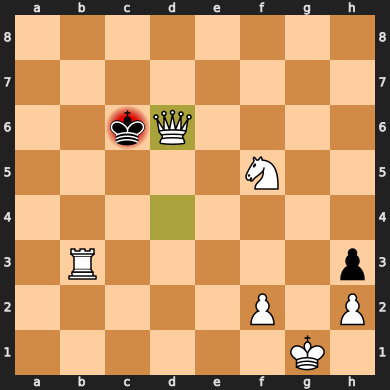

In [31]:
play_game(agents_big_normal[4], agents_big_L05_D075_W1_no_elo[4],  n_moves=150)

In [ ]:
results = []

for i in range(50):
    board = play_game(agents_small_normal[0], material_2, n_moves=150)
    results.append(board.result())
    print(board.result(), len(board.move_stack))
    if board.result() == '*':
        print(board.move_stack)
        display(board)

for i in range(50):
    board = play_game(material_2, agents_small_normal[0], n_moves=150)
    result = board.result()[::-1]
    results.append(result)
    print(result, len(board.move_stack))
    if result == '*':
        print(board.move_stack)
        display(board)

Counter(results)


In [27]:
material_3 = NegaMaxMaterialAgent(depth=3)

for agent in agents_small_normal:
    res = test_agent(agent, material_3, n_games=100, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0] 
    print(f"{wins}/{draws}/{losses}")

print('---------------------------------')

for agent in agents_small_L05_D075_W1:
    res = test_agent(agent, material_3, n_games=100, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0] 
    print(f"{wins}/{draws}/{losses}")

print('---------------------------------')


for agent in agents_big_normal:
    res = test_agent(agent, material_3, n_games=100, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0] 
    print(f"{wins}/{draws}/{losses}")

print('---------------------------------')


for agent in agents_big_L05_D075_W1:
    res = test_agent(agent, material_3, n_games=100, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0] 
    print(f"{wins}/{draws}/{losses}")

100%|██████████| 50/50 [03:17<00:00,  3.96s/it]


Counter({-1: 49, 0: 1})


100%|██████████| 50/50 [03:21<00:00,  4.04s/it]


Counter({1: 49, 0: 1})
0/2/98


100%|██████████| 50/50 [03:02<00:00,  3.65s/it]


Counter({-1: 48, 0: 2})


100%|██████████| 50/50 [03:30<00:00,  4.20s/it]


Counter({1: 49, -1: 1})
1/2/97


100%|██████████| 50/50 [02:53<00:00,  3.47s/it]


Counter({-1: 46, 0: 3, 1: 1})


100%|██████████| 50/50 [03:51<00:00,  4.63s/it]


Counter({1: 49, -1: 1})
2/3/95


100%|██████████| 50/50 [03:07<00:00,  3.76s/it]


Counter({-1: 44, 0: 4, 1: 2})


100%|██████████| 50/50 [03:41<00:00,  4.43s/it]


Counter({1: 44, 0: 4, -1: 2})
4/8/88


100%|██████████| 50/50 [03:20<00:00,  4.01s/it]


Counter({-1: 41, 0: 6, 1: 3})


100%|██████████| 50/50 [03:30<00:00,  4.22s/it]


Counter({1: 46, -1: 4})
7/6/87
---------------------------------


100%|██████████| 50/50 [02:36<00:00,  3.13s/it]


Counter({-1: 47, 1: 3})


100%|██████████| 50/50 [03:40<00:00,  4.41s/it]


Counter({1: 49, 0: 1})
3/1/96


100%|██████████| 50/50 [02:54<00:00,  3.49s/it]


Counter({-1: 46, 1: 3, 0: 1})


100%|██████████| 50/50 [04:06<00:00,  4.92s/it]


Counter({1: 45, 0: 4, -1: 1})
4/5/91


100%|██████████| 50/50 [03:18<00:00,  3.97s/it]


Counter({-1: 46, 1: 2, 0: 2})


100%|██████████| 50/50 [03:30<00:00,  4.20s/it]


Counter({1: 45, -1: 4, 0: 1})
6/3/91


100%|██████████| 50/50 [03:00<00:00,  3.61s/it]


Counter({-1: 46, 1: 3, 0: 1})


100%|██████████| 50/50 [03:04<00:00,  3.69s/it]


Counter({1: 46, -1: 3, 0: 1})
6/2/92


100%|██████████| 50/50 [03:14<00:00,  3.90s/it]


Counter({-1: 42, 1: 5, 0: 3})


100%|██████████| 50/50 [03:30<00:00,  4.21s/it]


Counter({1: 44, 0: 4, -1: 2})
7/7/86
---------------------------------


100%|██████████| 50/50 [04:10<00:00,  5.00s/it]


Counter({-1: 29, 1: 13, 0: 8})


100%|██████████| 50/50 [04:11<00:00,  5.02s/it]


Counter({1: 39, -1: 9, 0: 2})
22/10/68


100%|██████████| 50/50 [03:56<00:00,  4.72s/it]


Counter({-1: 27, 1: 17, 0: 6})


100%|██████████| 50/50 [04:26<00:00,  5.33s/it]


Counter({1: 27, -1: 17, 0: 6})
34/12/54


100%|██████████| 50/50 [04:11<00:00,  5.04s/it]


Counter({-1: 27, 1: 19, 0: 4})


100%|██████████| 50/50 [05:04<00:00,  6.08s/it]


Counter({1: 34, -1: 9, 0: 7})
28/11/61


100%|██████████| 50/50 [04:19<00:00,  5.19s/it]


Counter({1: 29, -1: 13, 0: 8})


100%|██████████| 50/50 [04:29<00:00,  5.39s/it]


Counter({1: 25, -1: 21, 0: 4})
50/12/38


100%|██████████| 50/50 [03:57<00:00,  4.74s/it]


Counter({1: 26, -1: 17, 0: 7})


100%|██████████| 50/50 [04:11<00:00,  5.02s/it]


Counter({-1: 27, 1: 18, 0: 5})
53/12/35
---------------------------------


100%|██████████| 50/50 [04:09<00:00,  4.99s/it]


Counter({-1: 37, 1: 7, 0: 6})


100%|██████████| 50/50 [05:32<00:00,  6.66s/it]


Counter({1: 38, 0: 7, -1: 5})
12/13/75


100%|██████████| 50/50 [03:45<00:00,  4.50s/it]


Counter({-1: 27, 1: 17, 0: 6})


100%|██████████| 50/50 [04:41<00:00,  5.63s/it]


Counter({1: 29, -1: 12, 0: 9})
29/15/56


100%|██████████| 50/50 [03:48<00:00,  4.58s/it]


Counter({-1: 24, 1: 20, 0: 6})


100%|██████████| 50/50 [04:05<00:00,  4.91s/it]


Counter({1: 23, -1: 20, 0: 7})
40/13/47


100%|██████████| 50/50 [04:05<00:00,  4.90s/it]


Counter({1: 25, -1: 21, 0: 4})


100%|██████████| 50/50 [04:39<00:00,  5.58s/it]


Counter({1: 25, -1: 21, 0: 4})
46/8/46


100%|██████████| 50/50 [03:46<00:00,  4.53s/it]


Counter({-1: 26, 1: 16, 0: 8})


100%|██████████| 50/50 [04:32<00:00,  5.44s/it]

Counter({1: 26, -1: 19, 0: 5})
35/13/52


In [19]:
material_3 = NegaMaxMaterialAgent(depth=3)

In [21]:
test_agent(agents_negamax_gpt[4], material_3, n_games=100, n_moves=150)

100%|██████████| 50/50 [07:46<00:00,  9.34s/it]


Counter({1: 46, -1: 4})


100%|██████████| 50/50 [08:36<00:00, 10.34s/it]

Counter({-1: 39, 1: 6, 0: 5})


{'white': Counter({1: 46, -1: 4}), 'black': Counter({-1: 39, 1: 6, 0: 5})}

In [22]:
results, points = agent_vs_maia(agents_negamax_gpt[4], n_moves=150)
print(points)
results

8.0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,0-1,Termination.CHECKMATE,152,False,#-0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,0-1,Termination.CHECKMATE,38,False,#-0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,95,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,54,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,103,False,#+0
8,white vs maia_1500,1/2-1/2,Termination.FIVEFOLD_REPETITION,147,True,#-2
9,black vs maia_1500,0-1,Termination.CHECKMATE,44,False,#-0


In [24]:
results, points = agent_vs_maia(agents_negamax_gpt[3], n_moves=150)
print(points)
results

11.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,0-1,Termination.CHECKMATE,118,False,#-0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,0-1,Termination.CHECKMATE,94,False,#-0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,87,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,56,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,109,False,#+0
8,white vs maia_1500,1/2-1/2,Termination.INSUFFICIENT_MATERIAL,130,False,0
9,black vs maia_1500,0-1,Termination.CHECKMATE,44,False,#-0


In [9]:
for i, agent in enumerate(agents_small_normal):
    results, points = agent_vs_maia(agent, n_moves=150)
    display(results)

,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1/2-1/2,Termination.FIVEFOLD_REPETITION,62,True,0
1,black vs maia_1100,1/2-1/2,Termination.FIVEFOLD_REPETITION,83,True,0
2,white vs maia_1200,1/2-1/2,Termination.FIVEFOLD_REPETITION,65,True,#-3
3,black vs maia_1200,1-0,Termination.CHECKMATE,153,False,#+0
4,white vs maia_1300,1/2-1/2,Termination.FIVEFOLD_REPETITION,70,True,0
5,black vs maia_1300,1-0,Termination.CHECKMATE,103,False,#+0
6,white vs maia_1400,1/2-1/2,Termination.FIVEFOLD_REPETITION,60,True,0
7,black vs maia_1400,1-0,Termination.CHECKMATE,41,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,58,False,#-0
9,black vs maia_1500,1/2-1/2,Termination.FIVEFOLD_REPETITION,76,True,+1154


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,85,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,85,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1/2-1/2,Termination.FIVEFOLD_REPETITION,58,True,+583
6,white vs maia_1400,0-1,Termination.CHECKMATE,80,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,87,False,#+0
8,white vs maia_1500,1/2-1/2,Termination.FIVEFOLD_REPETITION,89,True,0
9,black vs maia_1500,1-0,Termination.CHECKMATE,61,False,#+0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,59,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,77,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,73,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,98,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,77,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,76,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,63,False,#+0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,63,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,135,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,75,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,96,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,53,False,#+0
8,white vs maia_1500,1/2-1/2,Termination.FIVEFOLD_REPETITION,68,True,0
9,black vs maia_1500,0-1,Termination.CHECKMATE,42,False,#-0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,57,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1/2-1/2,Termination.STALEMATE,75,False,0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1/2-1/2,Termination.STALEMATE,65,False,0
6,white vs maia_1400,0-1,Termination.CHECKMATE,68,False,#-0
7,black vs maia_1400,1/2-1/2,Termination.STALEMATE,65,False,0
8,white vs maia_1500,0-1,Termination.CHECKMATE,62,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,131,False,#+0


In [78]:
for i, agent in enumerate(agents_big_normal):
    results, points = agent_vs_maia(agent, n_moves=150)
    display(results)

,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,77,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,89,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,95,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,44,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,69,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,94,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,107,False,#+0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,75,False,#+0
1,black vs maia_1100,0-1,Termination.CHECKMATE,120,False,#-0
2,white vs maia_1200,0-1,Termination.CHECKMATE,92,False,#-0
3,black vs maia_1200,1-0,Termination.CHECKMATE,53,False,#+0
4,white vs maia_1300,0-1,Termination.CHECKMATE,90,False,#-0
5,black vs maia_1300,0-1,Termination.CHECKMATE,74,False,#-0
6,white vs maia_1400,1-0,Termination.CHECKMATE,147,False,#+0
7,black vs maia_1400,1-0,Termination.CHECKMATE,103,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,68,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,79,False,#+0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,41,False,#+0
1,black vs maia_1100,1/2-1/2,Termination.FIVEFOLD_REPETITION,90,True,0
2,white vs maia_1200,1/2-1/2,Termination.INSUFFICIENT_MATERIAL,94,False,0
3,black vs maia_1200,0-1,Termination.CHECKMATE,30,False,#-0
4,white vs maia_1300,0-1,Termination.CHECKMATE,78,False,#-0
5,black vs maia_1300,0-1,Termination.CHECKMATE,90,False,#-0
6,white vs maia_1400,1-0,Termination.CHECKMATE,83,False,#+0
7,black vs maia_1400,1-0,Termination.CHECKMATE,121,False,#+0
8,white vs maia_1500,1-0,Termination.CHECKMATE,75,False,#+0
9,black vs maia_1500,1-0,Termination.CHECKMATE,85,False,#+0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,0-1,Termination.CHECKMATE,32,False,#-0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,0-1,Termination.CHECKMATE,88,False,#-0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,0-1,Termination.CHECKMATE,122,False,#-0
6,white vs maia_1400,1/2-1/2,Termination.INSUFFICIENT_MATERIAL,94,False,0
7,black vs maia_1400,1-0,Termination.CHECKMATE,89,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,44,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,125,False,#+0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,71,False,#+0
1,black vs maia_1100,1/2-1/2,Termination.FIVEFOLD_REPETITION,124,True,0
2,white vs maia_1200,1/2-1/2,Termination.FIVEFOLD_REPETITION,161,True,0
3,black vs maia_1200,1/2-1/2,Termination.FIVEFOLD_REPETITION,146,True,0
4,white vs maia_1300,1-0,Termination.CHECKMATE,85,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,131,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,66,False,#-0
7,black vs maia_1400,0-1,Termination.CHECKMATE,92,False,#-0
8,white vs maia_1500,1/2-1/2,Termination.INSUFFICIENT_MATERIAL,110,False,0
9,black vs maia_1500,0-1,Termination.CHECKMATE,40,False,#-0


In [77]:
for i, agent in enumerate(agents_big_L05_D075_W1):
    results, points = agent_vs_maia(agent, n_moves=150)
    display(results)

,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,65,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,67,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,67,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,64,False,#-0
7,black vs maia_1400,1/2-1/2,Termination.FIVEFOLD_REPETITION,90,True,0
8,white vs maia_1500,0-1,Termination.CHECKMATE,58,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,71,False,#+0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,0-1,Termination.CHECKMATE,34,False,#-0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,0-1,Termination.CHECKMATE,34,False,#-0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,91,False,#+0
6,white vs maia_1400,1-0,Termination.CHECKMATE,31,False,#+0
7,black vs maia_1400,0-1,Termination.CHECKMATE,66,False,#-0
8,white vs maia_1500,0-1,Termination.CHECKMATE,124,False,#-0
9,black vs maia_1500,1/2-1/2,Termination.FIVEFOLD_REPETITION,53,True,-512


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1/2-1/2,Termination.FIVEFOLD_REPETITION,74,True,0
1,black vs maia_1100,1-0,Termination.CHECKMATE,85,False,#+0
2,white vs maia_1200,0-1,Termination.CHECKMATE,64,False,#-0
3,black vs maia_1200,0-1,Termination.CHECKMATE,58,False,#-0
4,white vs maia_1300,0-1,Termination.CHECKMATE,48,False,#-0
5,black vs maia_1300,1-0,Termination.CHECKMATE,133,False,#+0
6,white vs maia_1400,1/2-1/2,Termination.FIVEFOLD_REPETITION,52,True,+579
7,black vs maia_1400,0-1,Termination.CHECKMATE,46,False,#-0
8,white vs maia_1500,0-1,Termination.CHECKMATE,110,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,105,False,#+0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,0-1,Termination.CHECKMATE,32,False,#-0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,109,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,0-1,Termination.CHECKMATE,56,False,#-0
6,white vs maia_1400,1-0,Termination.CHECKMATE,59,False,#+0
7,black vs maia_1400,0-1,Termination.CHECKMATE,38,False,#-0
8,white vs maia_1500,0-1,Termination.CHECKMATE,94,False,#-0
9,black vs maia_1500,0-1,Termination.CHECKMATE,52,False,#-0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1/2-1/2,Termination.FIVEFOLD_REPETITION,158,True,0
1,black vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
2,white vs maia_1200,1/2-1/2,Termination.FIVEFOLD_REPETITION,156,True,0
3,black vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
4,white vs maia_1300,0-1,Termination.CHECKMATE,70,False,#-0
5,black vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,66,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,17,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,88,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,17,False,#+0


In [8]:
for i, agent in enumerate(agents_big_L05_D075_W1_no_elo):
    results, points = agent_vs_maia(agent, n_moves=150)
    print(points)
    display(results)

2.0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1/2-1/2,Termination.FIVEFOLD_REPETITION,77,True,0
1,black vs maia_1100,1/2-1/2,Termination.FIVEFOLD_REPETITION,79,True,0
2,white vs maia_1200,0-1,Termination.CHECKMATE,84,False,#-0
3,black vs maia_1200,1-0,Termination.CHECKMATE,73,False,#+0
4,white vs maia_1300,0-1,Termination.CHECKMATE,94,False,#-0
5,black vs maia_1300,1-0,Termination.CHECKMATE,73,False,#+0
6,white vs maia_1400,1/2-1/2,Termination.FIVEFOLD_REPETITION,89,True,-823
7,black vs maia_1400,1-0,Termination.CHECKMATE,53,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,64,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,57,False,#+0


4.0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,37,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,81,False,#+0
2,white vs maia_1200,0-1,Termination.CHECKMATE,90,False,#-0
3,black vs maia_1200,1-0,Termination.CHECKMATE,63,False,#+0
4,white vs maia_1300,1/2-1/2,Termination.FIVEFOLD_REPETITION,84,True,0
5,black vs maia_1300,1-0,Termination.CHECKMATE,99,False,#+0
6,white vs maia_1400,1/2-1/2,Termination.FIVEFOLD_REPETITION,71,True,0
7,black vs maia_1400,1/2-1/2,Termination.FIVEFOLD_REPETITION,67,True,0
8,white vs maia_1500,0-1,Termination.CHECKMATE,102,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,37,False,#+0


6.0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1/2-1/2,Termination.STALEMATE,120,False,0
1,black vs maia_1100,1-0,Termination.CHECKMATE,37,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,109,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,37,False,#+0
4,white vs maia_1300,1/2-1/2,Termination.FIVEFOLD_REPETITION,81,True,-400
5,black vs maia_1300,1-0,Termination.CHECKMATE,97,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,86,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,105,False,#+0
8,white vs maia_1500,1-0,Termination.CHECKMATE,87,False,#+0
9,black vs maia_1500,0-1,Termination.CHECKMATE,58,False,#-0


4.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,54,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,17,False,#+0
8,white vs maia_1500,1-0,Termination.CHECKMATE,35,False,#+0
9,black vs maia_1500,1-0,Termination.CHECKMATE,17,False,#+0


12.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,0-1,Termination.CHECKMATE,50,False,#-0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,85,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,0-1,Termination.CHECKMATE,50,False,#-0
6,white vs maia_1400,1-0,Termination.CHECKMATE,53,False,#+0
7,black vs maia_1400,0-1,Termination.CHECKMATE,98,False,#-0
8,white vs maia_1500,1-0,Termination.CHECKMATE,31,False,#+0
9,black vs maia_1500,1-0,Termination.CHECKMATE,71,False,#+0


In [9]:
for i, agent in enumerate(agents_big_L05_D075_W1_eb0):
    results, points = agent_vs_maia(agent, n_moves=150)
    print(points)
    display(results)

4.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,105,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,0-1,Termination.CHECKMATE,40,False,#-0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,99,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,66,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,61,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,50,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,101,False,#+0


5.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1/2-1/2,Termination.FIVEFOLD_REPETITION,75,True,0
1,black vs maia_1100,1-0,Termination.CHECKMATE,41,False,#+0
2,white vs maia_1200,0-1,Termination.CHECKMATE,88,False,#-0
3,black vs maia_1200,1-0,Termination.CHECKMATE,37,False,#+0
4,white vs maia_1300,0-1,Termination.CHECKMATE,74,False,#-0
5,black vs maia_1300,1/2-1/2,Termination.STALEMATE,73,False,0
6,white vs maia_1400,0-1,Termination.CHECKMATE,94,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,73,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,54,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,75,False,#+0


7.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,47,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,65,False,#+0
2,white vs maia_1200,0-1,Termination.CHECKMATE,52,False,#-0
3,black vs maia_1200,1-0,Termination.CHECKMATE,87,False,#+0
4,white vs maia_1300,1/2-1/2,Termination.FIVEFOLD_REPETITION,68,True,0
5,black vs maia_1300,1-0,Termination.CHECKMATE,65,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,72,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,55,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,62,False,#-0
9,black vs maia_1500,1/2-1/2,Termination.FIVEFOLD_REPETITION,66,True,0


10.0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,0-1,Termination.CHECKMATE,52,False,#-0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,0-1,Termination.CHECKMATE,68,False,#-0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,55,False,#+0
6,white vs maia_1400,1-0,Termination.CHECKMATE,47,False,#+0
7,black vs maia_1400,1-0,Termination.CHECKMATE,107,False,#+0
8,white vs maia_1500,1-0,Termination.CHECKMATE,31,False,#+0
9,black vs maia_1500,1/2-1/2,Termination.FIVEFOLD_REPETITION,85,True,#-8


3.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,0-1,Termination.CHECKMATE,42,False,#-0
1,black vs maia_1100,1/2-1/2,Termination.FIVEFOLD_REPETITION,133,True,0
2,white vs maia_1200,0-1,Termination.CHECKMATE,46,False,#-0
3,black vs maia_1200,1-0,Termination.CHECKMATE,131,False,#+0
4,white vs maia_1300,0-1,Termination.CHECKMATE,62,False,#-0
5,black vs maia_1300,1/2-1/2,Termination.FIVEFOLD_REPETITION,112,True,0
6,white vs maia_1400,1-0,Termination.CHECKMATE,47,False,#+0
7,black vs maia_1400,1-0,Termination.CHECKMATE,113,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,78,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,109,False,#+0


In [17]:
for i, agent in enumerate(agents_small_normal):
    results, points = agent_vs_maia(agent, n_moves=150)
    print(f"{i+1}: {points}")

1: 4.5
2: 5.5
3: 3
4: 5.0
5: 5.0


In [18]:
for i, agent in enumerate(agents_small_L05_D075_W1):
    results, points = agent_vs_maia(agent, n_moves=150)
    print(f"{i+1}: {points}")

1: 4.0
2: 0.5
3: 3.5
4: 5.0
5: 6.0


In [19]:
for i, agent in enumerate(agents_big_normal):
    results, points = agent_vs_maia(agent, n_moves=150)
    print(f"{i+1}: {points}")

1: 3.5
2: 5.5
3: 8.5
4: 9.0
5: 8.0


In [20]:
for i, agent in enumerate(agents_big_L05_D075_W1):
    results, points = agent_vs_maia(agent, n_moves=150)
    print(f"{i+1}: {points}")

1: 4.0
2: 11.0
3: 5.5
4: 10.5
5: 3.5


In [25]:
openings = pd.read_csv("data/openings.csv")
openings = [op.split(" ") for op in openings.opening]

# test_agent_in_openings(agents_big_L05_D075_W1[3], maia_agents['maia_1400'], n_moves=150, openings=openings)

In [26]:
maia_1400 = maia_agents['maia_1400']

In [27]:
def test_agents_in_openings(agents, maia, n_moves=150, openings=None):
    results = []
    for i, agent in enumerate(agents):
        print(f"Agent {i+1}")
        res = test_agent_in_openings(agent, maia, n_moves=n_moves, openings=openings)
        wins = res['white'][1] + res['black'][-1]
        losses = res['white'][-1] + res['black'][1]
        draws = res['white'][0] + res['black'][0]
        print(res)
        print(f"{wins}/{draws}/{losses}")
        results.append(res)
    return results

In [28]:
test_agents_in_openings(agents_negamax_gpt[4:], maia_1400, n_moves=150, openings=openings)

Agent 1


100%|██████████| 100/100 [19:32<00:00, 11.73s/it]

{'white': Counter({1: 44, -1: 44, 0: 12}), 'black': Counter({-1: 43, 1: 34, 0: 23})}
87/35/78


[{'white': Counter({1: 44, -1: 44, 0: 12}),
  'black': Counter({-1: 43, 1: 34, 0: 23})}]

In [29]:
test_agents_in_openings(agents_negamax_gpt[4:], maia_agents['maia_1600'], n_moves=150, openings=openings)

Agent 1


100%|██████████| 100/100 [19:24<00:00, 11.64s/it]

{'white': Counter({1: 42, -1: 42, 0: 16}), 'black': Counter({1: 59, -1: 30, 0: 11})}
72/27/101


[{'white': Counter({1: 42, -1: 42, 0: 16}),
  'black': Counter({1: 59, -1: 30, 0: 11})}]

In [30]:
test_agents_in_openings(agents_negamax_gpt[4:], maia_agents['maia_1900'], n_moves=150, openings=openings)

Agent 1


100%|██████████| 100/100 [20:24<00:00, 12.25s/it]

{'white': Counter({-1: 53, 1: 32, 0: 15}), 'black': Counter({1: 54, -1: 30, 0: 16})}
62/31/107


[{'white': Counter({-1: 53, 1: 32, 0: 15}),
  'black': Counter({1: 54, -1: 30, 0: 16})}]

In [31]:
62+31/2

77.5

In [34]:
test_agents_in_openings(agents_big_L05_D075_W1_no_elo, maia_1400, n_moves=150, openings=openings)

Agent 1


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


{'white': Counter({-1: 80, 1: 11, 0: 9}), 'black': Counter({1: 85, 0: 9, -1: 6})}
17/18/165
Agent 2


100%|██████████| 100/100 [03:14<00:00,  1.94s/it]


{'white': Counter({-1: 61, 0: 21, 1: 18}), 'black': Counter({1: 67, -1: 18, 0: 15})}
36/36/128
Agent 3


100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


{'white': Counter({-1: 54, 0: 29, 1: 17}), 'black': Counter({1: 64, 0: 19, -1: 17})}
34/48/118
Agent 4


100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


{'white': Counter({-1: 48, 1: 30, 0: 22}), 'black': Counter({1: 62, -1: 28, 0: 10})}
58/32/110
Agent 5


100%|██████████| 100/100 [03:13<00:00,  1.93s/it]

{'white': Counter({-1: 46, 1: 38, 0: 16}), 'black': Counter({1: 59, -1: 21, 0: 20})}
59/36/105


[{'white': Counter({-1: 80, 1: 11, 0: 9}),
  'black': Counter({1: 85, 0: 9, -1: 6})},
 {'white': Counter({-1: 61, 0: 21, 1: 18}),
  'black': Counter({1: 67, -1: 18, 0: 15})},
 {'white': Counter({-1: 54, 0: 29, 1: 17}),
  'black': Counter({1: 64, 0: 19, -1: 17})},
 {'white': Counter({-1: 48, 1: 30, 0: 22}),
  'black': Counter({1: 62, -1: 28, 0: 10})},
 {'white': Counter({-1: 46, 1: 38, 0: 16}),
  'black': Counter({1: 59, -1: 21, 0: 20})}]

In [23]:

for agent in agents_big_normal:
    res = test_agent_in_openings(agent, maia_1400, openings=openings, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0]
    print(res)
    print(f"{wins}/{draws}/{losses}")

print('---------------------------------')

for agent in agents_big_L05_D075_W1:
    res = test_agent_in_openings(agent, maia_1400, openings=openings, n_moves=150)
    wins = res['white'][1] + res['black'][-1]
    losses = res['white'][-1] + res['black'][1]
    draws = res['white'][0] + res['black'][0]
    print(res)
    print(f"{wins}/{draws}/{losses}")

100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


{'white': Counter({-1: 75, 0: 14, 1: 11}), 'black': Counter({1: 77, 0: 12, -1: 11})}
22/26/152


100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


{'white': Counter({-1: 61, 1: 24, 0: 15}), 'black': Counter({1: 66, 0: 22, -1: 12})}
36/37/127


100%|██████████| 100/100 [03:44<00:00,  2.25s/it]


{'white': Counter({-1: 57, 1: 31, 0: 12}), 'black': Counter({1: 66, -1: 19, 0: 15})}
50/27/123


100%|██████████| 100/100 [03:33<00:00,  2.13s/it]


{'white': Counter({-1: 45, 1: 36, 0: 19}), 'black': Counter({1: 60, 0: 22, -1: 18})}
54/41/105


100%|██████████| 100/100 [03:28<00:00,  2.08s/it]


{'white': Counter({-1: 46, 1: 40, 0: 14}), 'black': Counter({1: 53, -1: 25, 0: 22})}
65/36/99
---------------------------------


100%|██████████| 100/100 [03:02<00:00,  1.83s/it]


{'white': Counter({-1: 77, 0: 14, 1: 9}), 'black': Counter({1: 74, 0: 19, -1: 7})}
16/33/151


100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


{'white': Counter({-1: 62, 1: 21, 0: 17}), 'black': Counter({1: 70, 0: 21, -1: 9})}
30/38/132


100%|██████████| 100/100 [03:07<00:00,  1.87s/it]


{'white': Counter({-1: 58, 1: 26, 0: 16}), 'black': Counter({1: 71, -1: 17, 0: 12})}
43/28/129


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


{'white': Counter({-1: 53, 1: 29, 0: 18}), 'black': Counter({1: 64, -1: 21, 0: 15})}
50/33/117


100%|██████████| 100/100 [03:31<00:00,  2.12s/it]

{'white': Counter({-1: 57, 1: 27, 0: 16}), 'black': Counter({1: 52, 0: 28, -1: 20})}
47/44/109


In [35]:
test_agents_in_openings(agents_big_normal, maia_agents['maia_1900'], n_moves=150, openings=openings)

Agent 1


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


{'white': Counter({-1: 86, 0: 10, 1: 4}), 'black': Counter({1: 84, 0: 11, -1: 5})}
9/21/170
Agent 2


100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


{'white': Counter({-1: 80, 0: 12, 1: 8}), 'black': Counter({1: 71, 0: 19, -1: 10})}
18/31/151
Agent 3


100%|██████████| 100/100 [03:30<00:00,  2.11s/it]


{'white': Counter({-1: 67, 0: 19, 1: 14}), 'black': Counter({1: 78, 0: 15, -1: 7})}
21/34/145
Agent 4


100%|██████████| 100/100 [03:47<00:00,  2.28s/it]


{'white': Counter({-1: 63, 0: 20, 1: 17}), 'black': Counter({1: 68, 0: 20, -1: 12})}
29/40/131
Agent 5


100%|██████████| 100/100 [03:45<00:00,  2.25s/it]

{'white': Counter({-1: 64, 1: 22, 0: 14}), 'black': Counter({1: 62, -1: 20, 0: 18})}
42/32/126


[{'white': Counter({-1: 86, 0: 10, 1: 4}),
  'black': Counter({1: 84, 0: 11, -1: 5})},
 {'white': Counter({-1: 80, 0: 12, 1: 8}),
  'black': Counter({1: 71, 0: 19, -1: 10})},
 {'white': Counter({-1: 67, 0: 19, 1: 14}),
  'black': Counter({1: 78, 0: 15, -1: 7})},
 {'white': Counter({-1: 63, 0: 20, 1: 17}),
  'black': Counter({1: 68, 0: 20, -1: 12})},
 {'white': Counter({-1: 64, 1: 22, 0: 14}),
  'black': Counter({1: 62, -1: 20, 0: 18})}]

In [36]:
test_agents_in_openings(agents_big_L05_D075_W1, maia_agents['maia_1900'], n_moves=150, openings=openings)

Agent 1


100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


{'white': Counter({-1: 84, 0: 9, 1: 7}), 'black': Counter({1: 83, 0: 14, -1: 3})}
10/23/167
Agent 2


100%|██████████| 100/100 [03:56<00:00,  2.36s/it]


{'white': Counter({-1: 79, 0: 12, 1: 9}), 'black': Counter({1: 76, 0: 19, -1: 5})}
14/31/155
Agent 3


100%|██████████| 100/100 [03:48<00:00,  2.28s/it]


{'white': Counter({-1: 71, 0: 19, 1: 10}), 'black': Counter({1: 67, 0: 20, -1: 13})}
23/39/138
Agent 4


100%|██████████| 100/100 [03:57<00:00,  2.37s/it]


{'white': Counter({-1: 62, 0: 25, 1: 13}), 'black': Counter({1: 74, -1: 16, 0: 10})}
29/35/136
Agent 5


100%|██████████| 100/100 [03:51<00:00,  2.31s/it]

{'white': Counter({-1: 61, 1: 20, 0: 19}), 'black': Counter({1: 72, 0: 16, -1: 12})}
32/35/133


[{'white': Counter({-1: 84, 0: 9, 1: 7}),
  'black': Counter({1: 83, 0: 14, -1: 3})},
 {'white': Counter({-1: 79, 0: 12, 1: 9}),
  'black': Counter({1: 76, 0: 19, -1: 5})},
 {'white': Counter({-1: 71, 0: 19, 1: 10}),
  'black': Counter({1: 67, 0: 20, -1: 13})},
 {'white': Counter({-1: 62, 0: 25, 1: 13}),
  'black': Counter({1: 74, -1: 16, 0: 10})},
 {'white': Counter({-1: 61, 1: 20, 0: 19}),
  'black': Counter({1: 72, 0: 16, -1: 12})}]

In [15]:
test_agents_in_openings(agents_big_L05_D075_W1_no_elo, maia_agents['maia_1900'], n_moves=150, openings=openings)

Agent 1


100%|██████████| 100/100 [02:59<00:00,  1.79s/it]


{'white': Counter({-1: 81, 0: 16, 1: 3}), 'black': Counter({1: 84, 0: 15, -1: 1})}
4/31/165
Agent 2


100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


{'white': Counter({-1: 68, 0: 21, 1: 11}), 'black': Counter({1: 78, 0: 18, -1: 4})}
15/39/146
Agent 3


100%|██████████| 100/100 [03:52<00:00,  2.33s/it]


{'white': Counter({-1: 68, 0: 21, 1: 11}), 'black': Counter({1: 74, 0: 15, -1: 11})}
22/36/142
Agent 4


100%|██████████| 100/100 [04:02<00:00,  2.42s/it]


{'white': Counter({-1: 67, 0: 18, 1: 15}), 'black': Counter({1: 72, 0: 14, -1: 14})}
29/32/139
Agent 5


100%|██████████| 100/100 [03:45<00:00,  2.25s/it]

{'white': Counter({-1: 65, 0: 21, 1: 14}), 'black': Counter({1: 70, 0: 21, -1: 9})}
23/42/135


[{'white': Counter({-1: 81, 0: 16, 1: 3}),
  'black': Counter({1: 84, 0: 15, -1: 1})},
 {'white': Counter({-1: 68, 0: 21, 1: 11}),
  'black': Counter({1: 78, 0: 18, -1: 4})},
 {'white': Counter({-1: 68, 0: 21, 1: 11}),
  'black': Counter({1: 74, 0: 15, -1: 11})},
 {'white': Counter({-1: 67, 0: 18, 1: 15}),
  'black': Counter({1: 72, 0: 14, -1: 14})},
 {'white': Counter({-1: 65, 0: 21, 1: 14}),
  'black': Counter({1: 70, 0: 21, -1: 9})}]

In [16]:
agents_types = [
    agents_big_normal[3:],
    agents_big_L05_D075_W1[3:],
    agents_big_L05_D075_W1_no_elo[3:],
]

In [17]:
for agents in agents_types:
    test_agents_in_openings(agents, maia_agents['maia_1100'], n_moves=150, openings=openings)
    print('-----------------')

Agent 1


100%|██████████| 100/100 [03:52<00:00,  2.32s/it]


{'white': Counter({-1: 45, 1: 44, 0: 11}), 'black': Counter({1: 42, -1: 30, 0: 28})}
74/39/87
Agent 2


100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


{'white': Counter({1: 43, -1: 39, 0: 18}), 'black': Counter({1: 44, -1: 33, 0: 23})}
76/41/83
-----------------
Agent 1


100%|██████████| 100/100 [03:46<00:00,  2.26s/it]


{'white': Counter({-1: 47, 1: 35, 0: 18}), 'black': Counter({1: 49, -1: 31, 0: 20})}
66/38/96
Agent 2


100%|██████████| 100/100 [04:07<00:00,  2.47s/it]


{'white': Counter({1: 42, -1: 36, 0: 22}), 'black': Counter({0: 35, 1: 33, -1: 32})}
74/57/69
-----------------
Agent 1


100%|██████████| 100/100 [03:54<00:00,  2.35s/it]


{'white': Counter({-1: 43, 1: 32, 0: 25}), 'black': Counter({1: 44, -1: 37, 0: 19})}
69/44/87
Agent 2


100%|██████████| 100/100 [04:02<00:00,  2.42s/it]

{'white': Counter({-1: 44, 1: 34, 0: 22}), 'black': Counter({1: 43, -1: 36, 0: 21})}
70/43/87
-----------------


In [18]:
for agents in agents_types:
    test_agents_in_openings(agents, maia_agents['maia_1600'], n_moves=150, openings=openings)
    print('-----------------')

Agent 1


100%|██████████| 100/100 [03:52<00:00,  2.33s/it]


{'white': Counter({-1: 60, 1: 20, 0: 20}), 'black': Counter({1: 52, -1: 25, 0: 23})}
45/43/112
Agent 2


100%|██████████| 100/100 [03:51<00:00,  2.31s/it]


{'white': Counter({-1: 52, 1: 27, 0: 21}), 'black': Counter({1: 53, 0: 24, -1: 23})}
50/45/105
-----------------
Agent 1


100%|██████████| 100/100 [03:48<00:00,  2.28s/it]


{'white': Counter({-1: 62, 0: 22, 1: 16}), 'black': Counter({1: 55, 0: 25, -1: 20})}
36/47/117
Agent 2


100%|██████████| 100/100 [03:42<00:00,  2.22s/it]


{'white': Counter({-1: 48, 1: 27, 0: 25}), 'black': Counter({1: 71, 0: 17, -1: 12})}
39/42/119
-----------------
Agent 1


100%|██████████| 100/100 [04:06<00:00,  2.46s/it]


{'white': Counter({-1: 51, 0: 25, 1: 24}), 'black': Counter({1: 60, 0: 24, -1: 16})}
40/49/111
Agent 2


100%|██████████| 100/100 [03:44<00:00,  2.24s/it]

{'white': Counter({-1: 55, 0: 25, 1: 20}), 'black': Counter({1: 63, -1: 19, 0: 18})}
39/43/118
-----------------


In [19]:
for agents in agents_types:
    test_agents_in_openings(agents, maia_agents['maia_1200'], n_moves=150, openings=openings)
    print('-----------------')

Agent 1


100%|██████████| 100/100 [03:40<00:00,  2.20s/it]


{'white': Counter({-1: 45, 1: 36, 0: 19}), 'black': Counter({1: 49, -1: 26, 0: 25})}
62/44/94
Agent 2


100%|██████████| 100/100 [03:18<00:00,  1.98s/it]


{'white': Counter({-1: 51, 1: 34, 0: 15}), 'black': Counter({-1: 40, 1: 36, 0: 24})}
74/39/87
-----------------
Agent 1


100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


{'white': Counter({-1: 51, 1: 28, 0: 21}), 'black': Counter({1: 48, -1: 30, 0: 22})}
58/43/99
Agent 2


100%|██████████| 100/100 [03:31<00:00,  2.12s/it]


{'white': Counter({-1: 45, 1: 33, 0: 22}), 'black': Counter({1: 49, 0: 26, -1: 25})}
58/48/94
-----------------
Agent 1


100%|██████████| 100/100 [03:25<00:00,  2.05s/it]


{'white': Counter({-1: 46, 1: 32, 0: 22}), 'black': Counter({1: 48, -1: 27, 0: 25})}
59/47/94
Agent 2


100%|██████████| 100/100 [03:14<00:00,  1.94s/it]

{'white': Counter({-1: 50, 1: 40, 0: 10}), 'black': Counter({1: 50, -1: 28, 0: 22})}
68/32/100
-----------------


In [67]:
def play_games(agent, opponent = None, n_moves=150, n_games=100):
    if opponent == None:
        opponent = RandomAgent()

    won_games = []
    draw_games = []
    lost_games = []
    unfinished_games = []

    for i in range(n_games//2):
        board = play_game(agent, opponent, n_moves=n_moves)
        if board.result() == "1-0":
            won_games.append(board)
        elif board.result() == "1/2-1/2":
            draw_games.append(board)
        elif board.result() == "0-1":
            lost_games.append(board)
        else:
            unfinished_games.append(board)

    for i in range(n_games//2):
        board = play_game(opponent, agent, n_moves=n_moves)
        if board.result() == "0-1":
            won_games.append(board)
        elif board.result() == "1/2-1/2":
            draw_games.append(board)
        elif board.result() == "1-0":
            lost_games.append(board)
        else:
            unfinished_games.append(board)

    return {"won": won_games, "draw": draw_games, "lost": lost_games, "unfinished": unfinished_games}

In [9]:
checkpoint_elo_1100 = "./lightning_logs/rating_bins/elo_1100/version_3/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1200 = "./lightning_logs/rating_bins/elo_1200/version_0/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1300 = "./lightning_logs/rating_bins/elo_1300/version_3/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1400 = "./lightning_logs/rating_bins/elo_1400/version_2/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1500 = "./lightning_logs/rating_bins/elo_1500/version_1/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1600 = "./lightning_logs/rating_bins/elo_1600/version_5/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1700 = "./lightning_logs/rating_bins/elo_1700/version_1/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1800 = "./lightning_logs/rating_bins/elo_1800/version_0/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1900 = "./lightning_logs/rating_bins/elo_1900/version_2/checkpoints/epoch=9-step=937500.ckpt"

checkpoints = {
    "gpt_1100": checkpoint_elo_1100,
    "gpt_1200": checkpoint_elo_1200,
    "gpt_1300": checkpoint_elo_1300,
    "gpt_1400": checkpoint_elo_1400,
    "gpt_1500": checkpoint_elo_1500,
    "gpt_1600": checkpoint_elo_1600,
    "gpt_1700": checkpoint_elo_1700,
    "gpt_1800": checkpoint_elo_1800,
    "gpt_1900": checkpoint_elo_1900,
}

agents = {}

for name, checkpoint in checkpoints.items():
    model = load_model_from_checkpoint(checkpoint, model_config)
    agent = GPTAgent(model)

    agents[name] = agent

number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M
number of parameters: 4.19M


In [ ]:
for name, agent in agents.items():
    results, points = agent_vs_maia(agent, n_moves=150)
    display(results)

In [20]:
for agent_name, agent in agents.items():
    print(agent_name)
    print(test_agent(agent, n_games=100, n_moves=40))

gpt_1100


100%|██████████| 50/50 [00:05<00:00,  9.91it/s]


Counter({1: 49, 0: 1})


100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


Counter({-1: 48, 0: 2})
{'white': Counter({1: 49, 0: 1}), 'black': Counter({-1: 48, 0: 2})}
gpt_1200


100%|██████████| 50/50 [00:07<00:00,  7.13it/s]


Counter({1: 49, 0: 1})


100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


Counter({-1: 44, 0: 6})
{'white': Counter({1: 49, 0: 1}), 'black': Counter({-1: 44, 0: 6})}
gpt_1300


100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


Counter({1: 48, 0: 2})


100%|██████████| 50/50 [00:09<00:00,  5.15it/s]


Counter({-1: 46, 0: 4})
{'white': Counter({1: 48, 0: 2}), 'black': Counter({-1: 46, 0: 4})}
gpt_1400


100%|██████████| 50/50 [00:05<00:00,  9.74it/s]


Counter({1: 46, 0: 4})


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


Counter({-1: 48, 0: 2})
{'white': Counter({1: 46, 0: 4}), 'black': Counter({-1: 48, 0: 2})}
gpt_1500


100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Counter({1: 46, 0: 4})


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


Counter({-1: 44, 0: 5, 1: 1})
{'white': Counter({1: 46, 0: 4}), 'black': Counter({-1: 44, 0: 5, 1: 1})}
gpt_1600


100%|██████████| 50/50 [00:06<00:00,  7.90it/s]


Counter({1: 47, 0: 3})


100%|██████████| 50/50 [00:12<00:00,  3.86it/s]


Counter({-1: 45, 0: 5})
{'white': Counter({1: 47, 0: 3}), 'black': Counter({-1: 45, 0: 5})}
gpt_1700


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


Counter({1: 46, 0: 4})


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Counter({-1: 46, 0: 4})
{'white': Counter({1: 46, 0: 4}), 'black': Counter({-1: 46, 0: 4})}
gpt_1800


100%|██████████| 50/50 [00:05<00:00,  8.48it/s]


Counter({1: 50})


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


Counter({-1: 48, 0: 2})
{'white': Counter({1: 50}), 'black': Counter({-1: 48, 0: 2})}
gpt_1900


100%|██████████| 50/50 [00:06<00:00,  7.21it/s]


Counter({1: 48, 0: 2})


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]

Counter({-1: 44, 0: 6})
{'white': Counter({1: 48, 0: 2}), 'black': Counter({-1: 44, 0: 6})}


In [21]:
for agent_name, agent in agents.items():
    print(agent_name)
    print(test_agent(agent, n_games=100, n_moves=150))

gpt_1100


100%|██████████| 50/50 [00:06<00:00,  7.73it/s]


Counter({1: 47, 0: 3})


100%|██████████| 50/50 [00:06<00:00,  7.73it/s]


Counter({-1: 44, 0: 6})
{'white': Counter({1: 47, 0: 3}), 'black': Counter({-1: 44, 0: 6})}
gpt_1200


100%|██████████| 50/50 [00:08<00:00,  5.97it/s]


Counter({1: 46, 0: 4})


100%|██████████| 50/50 [00:07<00:00,  6.43it/s]


Counter({-1: 48, 0: 2})
{'white': Counter({1: 46, 0: 4}), 'black': Counter({-1: 48, 0: 2})}
gpt_1300


100%|██████████| 50/50 [00:08<00:00,  5.97it/s]


Counter({1: 47, 0: 3})


100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


Counter({-1: 45, 0: 5})
{'white': Counter({1: 47, 0: 3}), 'black': Counter({-1: 45, 0: 5})}
gpt_1400


100%|██████████| 50/50 [00:05<00:00,  9.79it/s]


Counter({1: 44, 0: 6})


100%|██████████| 50/50 [00:07<00:00,  6.74it/s]


Counter({-1: 44, 0: 6})
{'white': Counter({1: 44, 0: 6}), 'black': Counter({-1: 44, 0: 6})}
gpt_1500


100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


Counter({1: 46, 0: 4})


100%|██████████| 50/50 [00:06<00:00,  7.68it/s]


Counter({-1: 43, 0: 7})
{'white': Counter({1: 46, 0: 4}), 'black': Counter({-1: 43, 0: 7})}
gpt_1600


100%|██████████| 50/50 [00:06<00:00,  7.86it/s]


Counter({1: 43, 0: 7})


100%|██████████| 50/50 [00:08<00:00,  6.16it/s]


Counter({-1: 42, 0: 8})
{'white': Counter({1: 43, 0: 7}), 'black': Counter({-1: 42, 0: 8})}
gpt_1700


100%|██████████| 50/50 [00:06<00:00,  7.27it/s]


Counter({1: 45, 0: 5})


100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Counter({-1: 38, 0: 12})
{'white': Counter({1: 45, 0: 5}), 'black': Counter({-1: 38, 0: 12})}
gpt_1800


100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


Counter({1: 44, 0: 6})


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Counter({-1: 43, 0: 7})
{'white': Counter({1: 44, 0: 6}), 'black': Counter({-1: 43, 0: 7})}
gpt_1900


100%|██████████| 50/50 [00:09<00:00,  5.08it/s]


Counter({1: 43, 0: 7})


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]

Counter({-1: 38, 0: 12})
{'white': Counter({1: 43, 0: 7}), 'black': Counter({-1: 38, 0: 12})}


In [18]:
for name, agent in agents.items():
    print(name)

    results_df = agent_vs_maia(agent, n_moves=150)

    display(results_df)

gpt_1100
Points: 5.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,68,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,17,False,#+0
8,white vs maia_1500,1-0,Termination.CHECKMATE,73,False,#+0
9,black vs maia_1500,1-0,Termination.CHECKMATE,17,False,#+0


gpt_1200
Points: 4.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
6,white vs maia_1400,1/2-1/2,Termination.FIVEFOLD_REPETITION,93,True,#-5
7,black vs maia_1400,1-0,Termination.CHECKMATE,17,False,#+0
8,white vs maia_1500,1/2-1/2,Termination.FIVEFOLD_REPETITION,60,True,0
9,black vs maia_1500,1-0,Termination.CHECKMATE,17,False,#+0


gpt_1300
Points: 4.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,19,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,19,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,19,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,56,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,19,False,#+0
8,white vs maia_1500,1/2-1/2,Termination.FIVEFOLD_REPETITION,58,True,0
9,black vs maia_1500,1-0,Termination.CHECKMATE,19,False,#+0


gpt_1400
Points: 4.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
6,white vs maia_1400,1/2-1/2,Termination.FIVEFOLD_REPETITION,139,True,0
7,black vs maia_1400,1-0,Termination.CHECKMATE,17,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,46,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,17,False,#+0


gpt_1500
Points: 3.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
1,black vs maia_1100,1-0,Termination.CHECKMATE,17,False,#+0
2,white vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
3,black vs maia_1200,1-0,Termination.CHECKMATE,17,False,#+0
4,white vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
5,black vs maia_1300,1-0,Termination.CHECKMATE,17,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,74,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,17,False,#+0
8,white vs maia_1500,1/2-1/2,Termination.STALEMATE,116,False,0
9,black vs maia_1500,1-0,Termination.CHECKMATE,17,False,#+0


gpt_1600
Points: 4.0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,0-1,Termination.CHECKMATE,60,False,#-0
1,black vs maia_1100,1-0,Termination.CHECKMATE,81,False,#+0
2,white vs maia_1200,0-1,Termination.CHECKMATE,76,False,#-0
3,black vs maia_1200,1-0,Termination.CHECKMATE,73,False,#+0
4,white vs maia_1300,1/2-1/2,Termination.FIVEFOLD_REPETITION,69,True,-982
5,black vs maia_1300,0-1,Termination.CHECKMATE,72,False,#-0
6,white vs maia_1400,0-1,Termination.CHECKMATE,74,False,#-0
7,black vs maia_1400,1/2-1/2,Termination.FIVEFOLD_REPETITION,83,True,0
8,white vs maia_1500,1/2-1/2,Termination.STALEMATE,92,False,0
9,black vs maia_1500,1-0,Termination.CHECKMATE,103,False,#+0


gpt_1700
Points: 3.5


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1/2-1/2,Termination.STALEMATE,96,False,0
1,black vs maia_1100,1-0,Termination.CHECKMATE,89,False,#+0
2,white vs maia_1200,1/2-1/2,Termination.STALEMATE,104,False,0
3,black vs maia_1200,1-0,Termination.CHECKMATE,83,False,#+0
4,white vs maia_1300,1/2-1/2,Termination.FIVEFOLD_REPETITION,74,True,0
5,black vs maia_1300,1-0,Termination.CHECKMATE,115,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,72,False,#-0
7,black vs maia_1400,0-1,Termination.CHECKMATE,102,False,#-0
8,white vs maia_1500,0-1,Termination.CHECKMATE,68,False,#-0
9,black vs maia_1500,1/2-1/2,Termination.FIVEFOLD_REPETITION,89,True,0


gpt_1800
Points: 2.0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,1/2-1/2,Termination.FIVEFOLD_REPETITION,68,True,0
1,black vs maia_1100,1-0,Termination.CHECKMATE,63,False,#+0
2,white vs maia_1200,0-1,Termination.CHECKMATE,98,False,#-0
3,black vs maia_1200,0-1,Termination.CHECKMATE,30,False,#-0
4,white vs maia_1300,0-1,Termination.CHECKMATE,70,False,#-0
5,black vs maia_1300,1-0,Termination.CHECKMATE,105,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,82,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,115,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,44,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,99,False,#+0


gpt_1900
Points: 1.0


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,0-1,Termination.CHECKMATE,94,False,#-0
1,black vs maia_1100,1-0,Termination.CHECKMATE,27,False,#+0
2,white vs maia_1200,1/2-1/2,Termination.FIVEFOLD_REPETITION,87,True,-165
3,black vs maia_1200,1-0,Termination.CHECKMATE,107,False,#+0
4,white vs maia_1300,0-1,Termination.CHECKMATE,92,False,#-0
5,black vs maia_1300,1-0,Termination.CHECKMATE,27,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,100,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,47,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,132,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,55,False,#+0


In [11]:
square_token_agent = GPTSquareTokenAgent()

In [13]:
res, points = agent_vs_maia(square_token_agent, n_moves=150)
print(points)
display(res)

1


,game,result,termination,n_moves,repetition,stockfish_score
0,white vs maia_1100,0-1,Termination.CHECKMATE,44,False,#-0
1,black vs maia_1100,1-0,Termination.CHECKMATE,75,False,#+0
2,white vs maia_1200,0-1,Termination.CHECKMATE,28,False,#-0
3,black vs maia_1200,0-1,Termination.CHECKMATE,88,False,#-0
4,white vs maia_1300,0-1,Termination.CHECKMATE,46,False,#-0
5,black vs maia_1300,1-0,Termination.CHECKMATE,91,False,#+0
6,white vs maia_1400,0-1,Termination.CHECKMATE,50,False,#-0
7,black vs maia_1400,1-0,Termination.CHECKMATE,73,False,#+0
8,white vs maia_1500,0-1,Termination.CHECKMATE,50,False,#-0
9,black vs maia_1500,1-0,Termination.CHECKMATE,55,False,#+0


In [15]:
# Mój GPT vs GPT z "Chess as a testbed..."

print(test_agent(agent, square_token_agent, n_games=100))
print(square_token_agent.random_move_count)
# results = []

# for i in range(10):
#     board = play_game(agent, square_token_agent, verbose=False)
#     print(simple_result(board))
#     display(board)

100%|██████████| 50/50 [05:07<00:00,  6.16s/it]


Counter({1: 43, 0: 5, -1: 2})


100%|██████████| 50/50 [06:51<00:00,  8.23s/it]

Counter({-1: 50})
{'white': Counter({1: 43, 0: 5, -1: 2}), 'black': Counter({-1: 50})}
236
